In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.preprocessing import normalize
from catboost import CatBoostClassifier

# Preprocessing

In [2]:
def creating_dataset(filename):
    df = pd.read_csv('dataset/'+str(filename), index_col=[0])
    X = df.drop('DEP_DEL15', axis=1).drop("LONGITUDE",axis=1).drop("LATITUDE",axis=1)
    y = df['DEP_DEL15']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
    x_train,x_test = scaleNorm(x_train,x_test)
    return x_train,x_test,y_train,y_test

def redoSplit(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,shuffle=True)
    return x_train,x_test,y_train,y_test

def standardize(x):
    x = x.to_numpy()
    x = (x- np.min(x,axis=0))/np.max(x,axis=0)
    return x

def scaleNorm(X_train,X_test):
    X_train = standardize(X_train)
    X_test = standardize(X_test)
    return pd.DataFrame(X_train),pd.DataFrame(X_test)

def bestFittingMethod(x,y):
    weights = y.to_numpy()*4 + 1
    xb_modelW = xgb.XGBClassifier(weight=weights)
    xb_modelW.fit(x, y)
    return xb_modelW

 # Current best model

In [3]:
X,x_real_test,Y,y_real_test = creating_dataset('datasetcleaned_full.csv')
cols = pd.read_csv('dataset/datasetcleaned.csv', index_col=[0]).drop('DEP_DEL15', axis=1).drop("LONGITUDE",axis=1).drop("LATITUDE",axis=1).columns

In [4]:
x_train,x_test,y_train,y_test = redoSplit(X,Y)

In [5]:
#with weights
xb_modelW = bestFittingMethod(x_train,y_train)
y_hat = xb_modelW.predict(x_test)
cm = confusion_matrix(y_test, y_hat)
print(cm /np.sum(cm,axis=0))

/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[0.820287   0.32659458]
 [0.179713   0.67340542]]


In [6]:
cols[np.argsort(xb_modelW.feature_importances_)]

Index(['PREVIOUS_AIRPORT', 'PLANE_AGE', 'AIRLINE_AIRPORT_FLIGHTS_MONTH',
       'CONCURRENT_FLIGHTS', 'AWND', 'DEPARTING_AIRPORT', 'SNWD',
       'DAY_OF_WEEK', 'NUMBER_OF_SEATS', 'DISTANCE_GROUP',
       'AIRPORT_FLIGHTS_MONTH', 'TMAX', 'CARRIER_NAME',
       'AIRLINE_FLIGHTS_MONTH', 'SNOW', 'FLT_ATTENDANTS_PER_PASS',
       'AVG_MONTHLY_PASS_AIRPORT', 'GROUND_SERV_PER_PASS',
       'AVG_MONTHLY_PASS_AIRLINE', 'MONTH', 'SEGMENT_NUMBER', 'PRCP',
       'DEP_BLOCK'],
      dtype='object')

# Feature selection

## F scores

In [7]:
def computingFscoresAccuracies(verbose = False):
    f_scores_train = []
    f_scores_test = []
    delay_hits = []
    nondelay_hits = []
    for k in tqdm(range(1,15)):
        x_train,x_test,y_train,y_test = redoSplit(X,Y)
        Kbest_f = SelectKBest(f_classif, k=k).fit(x_train, y_train)
        Xf = Kbest_f.transform(x_train)
        Xf_test = Kbest_f.transform(x_test)
        #fitting
        clf = bestFittingMethod(Xf,y_train)
        #accuracy
        #train
        y_pred_train = clf.predict(Xf)
        Train_f_score = f1_score(y_train.to_numpy(),y_pred_train)
        f_scores_train.append(Train_f_score)
        #test
        y_pred_test = clf.predict(Xf_test)
        f_score_test = f1_score(y_test.to_numpy(),y_pred_test)
        f_scores_test.append(f_score_test)
        cm_test = confusion_matrix(y_test.to_numpy(),y_pred_test)
        n_cm_test = cm_test /np.sum(cm_test,axis=0)
        nondelay_hits.append(n_cm_test[0,0])
        delay_hits.append(n_cm_test[1,1])
        if verbose: 
            train_acc,t_acc = clf.score(Xf, y_train), clf.score(Xf_test, y_test)
            cm = confusion_matrix(y_train.to_numpy(),y_pred_train)
            print(f"---k={k_f}-----------------------------------------------------")
            print("Train accuracy",train_acc)
            print("Test accuracy",t_acc)
            print("confusion matrix train \n",cm /np.sum(cm,axis=0))
            print("train score:",clf.score(Xf,y_train))
            print("train f-score:",Train_f_score)
            print("confusion matrix test \n",cm_test /np.sum(cm_test,axis=0))
            print("test score:",clf.score(Xf_test,y_test))
            print("test f-score:",f_score_test)
    return f_scores_train,f_scores_test,delay_hits,nondelay_hits

In [8]:
f_scores_train,f_scores_test,df,ndf = computingFscoresAccuracies(verbose=False)

  0%|          | 0/14 [00:00<?, ?it/s]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:42:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:42:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-7-0ded281e3517>:23: RuntimeWarning: invalid value encountered in true_divide
  n_cm_test = cm_test /np.sum(cm_test,axis=0)
  7%|▋         | 1/14 [00:26<05:49, 26.92s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:43:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 14%|█▍        | 2/14 [01:12<06:31, 32.62s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:43:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 21%|██▏       | 3/14 [01:59<06:45, 36.86s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:44:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▊       | 4/14 [02:53<07:00, 42.05s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:45:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:45:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 36%|███▌      | 5/14 [03:51<07:00, 46.71s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:46:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 43%|████▎     | 6/14 [05:07<07:23, 55.42s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:47:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 7/14 [06:31<07:28, 64.02s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 57%|█████▋    | 8/14 [07:57<07:04, 70.67s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 64%|██████▍   | 9/14 [09:41<06:43, 80.74s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:52:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:52:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████▏  | 10/14 [11:34<06:01, 90.44s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:54:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|███████▊  | 11/14 [13:33<04:57, 99.03s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:56:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 86%|████████▌ | 12/14 [15:36<03:32, 106.10s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:58:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 13/14 [17:49<01:54, 114.08s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:00:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 14/14 [20:20<00:00, 87.17s/it] 


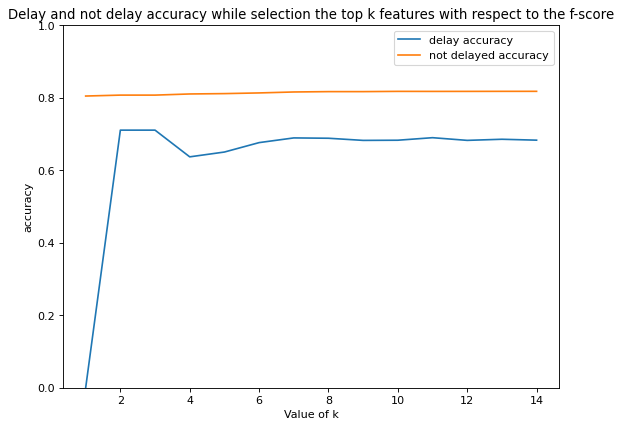

In [61]:
#we replace nan values
plt.figure(figsize=(8, 6), dpi=80)
df = np.array(df)
s=np.isnan(df)
df[s]=0.0
plt.plot(np.arange(1,15),df,label="delay accuracy")
plt.plot(np.arange(1,15),ndf,label="not delayed accuracy")
plt.xlabel("Value of k")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.legend()
plt.title(r"Delay and not delay accuracy while selection the top k features with respect to the f-score")
plt.savefig("Viz/f_scores.png")
plt.show()

In [49]:
#checking that 3 features are enough
x_train,x_test,y_train,y_test = redoSplit(X,Y)
Kbest_f = SelectKBest(f_classif, k=3).fit(x_train, y_train)
Xf = Kbest_f.transform(x_train)
Xf_test = Kbest_f.transform(x_test)
#fitting
clf = bestFittingMethod(Xf,y_train)
#test
y_pred_test = clf.predict(Xf_test)
cm_test = confusion_matrix(y_test.to_numpy(),y_pred_test)
n_cm_test = cm_test /np.sum(cm_test,axis=0)
print(n_cm_test)

/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[0.80757585 0.28908014]
 [0.19242415 0.71091986]]


In [50]:
#extracting the features
print(cols[np.where(Kbest_f.get_support())[0]])

Index(['DEP_BLOCK', 'SEGMENT_NUMBER', 'PREVIOUS_AIRPORT'], dtype='object')


In [10]:
num_to_col = dict(enumerate(cols))
scores,p_values = f_classif(x_train,y_train)
k = len(scores)
for i in reversed(range(k)):
    print(num_to_col[np.argsort(scores)[-k:][i]],np.log(np.sort(scores)[-k:][i]))

SEGMENT_NUMBER 10.681482391311258
DEP_BLOCK 10.656031782554445
PREVIOUS_AIRPORT 10.656031782554445
PRCP 9.992911022662422
SNOW 8.804086937003149
AWND 8.694492274380645
AIRPORT_FLIGHTS_MONTH 7.701284546474037
AVG_MONTHLY_PASS_AIRPORT 7.566433768304431
SNWD 7.436255000457875
GROUND_SERV_PER_PASS 6.747622888540228
CONCURRENT_FLIGHTS 6.686821892161342
DISTANCE_GROUP 6.629927975444459
CARRIER_NAME 6.528844211079413
AIRLINE_AIRPORT_FLIGHTS_MONTH 6.40720805710237
NUMBER_OF_SEATS 6.174582948943064
DEPARTING_AIRPORT 5.354652824200494
MONTH 4.463189884028675
PLANE_AGE 4.441299864482742
TMAX 3.8107658426274083
FLT_ATTENDANTS_PER_PASS 3.116708019031586
DAY_OF_WEEK 1.332891523647258
AIRLINE_FLIGHTS_MONTH -0.49127200185178754
AVG_MONTHLY_PASS_AIRLINE -3.248985307150203


 ## $\chi^2$ feature selection

In [11]:
def computingChi2scoresAccuracies(verbose = False):
    #X need to be non negative to apply this method
    chi2_scores_train = []
    chi2_scores_test = []
    delay_hits = []
    nondelay_hits = []
    for k in tqdm(range(1,15)):
        x_train,x_test,y_train,y_test = redoSplit(X,Y)
        x_chi2 = x_train.copy()
        x_chi2_test = x_test.copy()
        Kbest_chi2 = SelectKBest(chi2, k=k).fit(x_chi2, y_train)
        Xchi2 = Kbest_chi2.transform(x_chi2)
        XTchi2 = Kbest_chi2.transform(x_chi2_test)
        #fitting
        clf = bestFittingMethod(Xchi2,y_train)
        #accuracy
        #train
        y_pred_train = clf.predict(Xchi2)
        Train_chi2_score = f1_score(y_train.to_numpy(),y_pred_train)
        chi2_scores_train.append(Train_chi2_score)
        #test
        y_pred_test = clf.predict(XTchi2)
        Test_chi2_score = f1_score(y_test.to_numpy(),y_pred_test)
        chi2_scores_test.append(Test_chi2_score)
        cm_test = confusion_matrix(y_test.to_numpy(),y_pred_test)
        n_cm_test = cm_test /np.sum(cm_test,axis=0)
        nondelay_hits.append(n_cm_test[0,0])
        delay_hits.append(n_cm_test[1,1])
        if verbose: 
            cm = confusion_matrix(y_train.to_numpy(),y_pred_train,)
            print(f"---k={k_f}-----------------------------------------------------")
            print("confusion matrix train \n",cm /np.sum(cm,axis=0))
            print("train f-score:",Train_f_score)
            print("confusion matrix test \n",cm_test /np.cm_test(cm,axis=0))
            print("test chi2-score:",Test_chi2_score)
    return chi2_scores_train,chi2_scores_test,delay_hits,nondelay_hits

In [12]:
chi2_scores_train,chi2_scores_test,d_chi2,nd_chi2 = computingChi2scoresAccuracies()

  0%|          | 0/14 [00:00<?, ?it/s]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:03:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-11-29339d59c005>:26: RuntimeWarning: invalid value encountered in true_divide
  n_cm_test = cm_test /np.sum(cm_test,axis=0)
  7%|▋         | 1/14 [00:23<05:05, 23.54s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:03:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-11-29339d59c005>:26: RuntimeWarning: invalid value encountered in true_divide
  n_cm_test = cm_test /np.sum(cm_test,axis=0)
 14%|█▍        | 2/14 [00:46<04:41, 23.42s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:03:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 21%|██▏       | 3/14 [01:35<05:40, 30.97s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▊       | 4/14 [02:31<06:26, 38.61s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:05:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 36%|███▌      | 5/14 [03:31<06:44, 44.91s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:06:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 43%|████▎     | 6/14 [04:53<07:28, 56.02s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:07:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 7/14 [06:17<07:30, 64.37s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:09:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 57%|█████▋    | 8/14 [07:44<07:08, 71.35s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:10:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 64%|██████▍   | 9/14 [09:34<06:55, 83.01s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:12:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████▏  | 10/14 [11:44<06:28, 97.04s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:14:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|███████▊  | 11/14 [13:50<05:17, 105.67s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:16:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 86%|████████▌ | 12/14 [16:02<03:47, 113.58s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:19:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 13/14 [18:24<02:02, 122.03s/it]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:21:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 14/14 [20:50<00:00, 89.35s/it] 


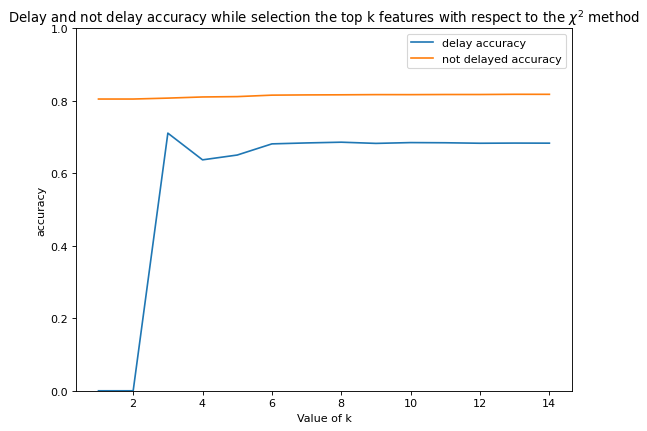

In [58]:
plt.figure(figsize=(8, 6), dpi=80)
d_chi2 = np.array(d_chi2)
s=np.isnan(d_chi2)
d_chi2[s]=0.0
plt.plot(np.arange(1,15),d_chi2,label="delay accuracy")
plt.plot(np.arange(1,15),nd_chi2,label="not delayed accuracy")
plt.xlabel("Value of k")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title(r"Delay and not delay accuracy while selection the top k features with respect to the $\chi^2$ method")
plt.legend()
plt.savefig("Viz/chi2.png")
plt.show()

In [51]:
#checking that 3 features are enough
x_train,x_test,y_train,y_test = redoSplit(X,Y)
Kbest_chi2 = SelectKBest(chi2, k=3).fit(x_train, y_train)
Xchi2 = Kbest_chi2.transform(x_train)
XTchi2 = Kbest_chi2.transform(x_test)
#fitting
clf = bestFittingMethod(Xchi2,y_train)
#confustion matrix
y_pred_test = clf.predict(XTchi2)
cm_test = confusion_matrix(y_test.to_numpy(),y_pred_test)
n_cm_test = cm_test /np.sum(cm_test,axis=0)

/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:32:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
#extracting the features
print(cols[np.where(Kbest_chi2.get_support())[0]])

Index(['DEP_BLOCK', 'SEGMENT_NUMBER', 'PREVIOUS_AIRPORT'], dtype='object')


In [14]:
scores,p_values = chi2(x_train,y_train)
k = len(scores)
print("printing log scores")
for i in reversed(range(k)):
    print(cols[np.argsort(scores)[-k:][i]],np.log(np.sort(scores)[-k:][i]))

printing log scores
PREVIOUS_AIRPORT 9.288961481676045
DEP_BLOCK 9.288961481676045
SEGMENT_NUMBER 8.372362261608606
PRCP 7.999030374764202
SNOW 7.11965947438794
AIRPORT_FLIGHTS_MONTH 6.056270639380346
SNWD 5.971266952458197
AVG_MONTHLY_PASS_AIRPORT 5.9094153385796515
AWND 5.605164576233252
AIRLINE_AIRPORT_FLIGHTS_MONTH 4.987093960677856
DISTANCE_GROUP 4.932385693947276
CONCURRENT_FLIGHTS 4.900216060566372
CARRIER_NAME 4.820649656703487
GROUND_SERV_PER_PASS 4.13629353918607
DEPARTING_AIRPORT 3.6556221086478295
NUMBER_OF_SEATS 3.5344672589143515
MONTH 2.703814105844175
PLANE_AGE 2.403057228840098
FLT_ATTENDANTS_PER_PASS 1.6018495649070927
TMAX 0.49895527484131313
DAY_OF_WEEK -0.3234928732493158
AIRLINE_FLIGHTS_MONTH -2.2215141006250048
AVG_MONTHLY_PASS_AIRLINE -4.599451059686874


# PCA 

In [15]:
def computingPCAscoresAccuracies(verbose = False):
    scores_train = []
    scores_test = []
    delay_hits = []
    nondelay_hits = []
    for k in tqdm(range(1,15)):
        x_train,x_test,y_train,y_test = redoSplit(X,Y)
        #transforming
        pca = PCA(n_components=k)
        pca.fit(x_train)
        Xpca = pca.transform(x_train)
        Xpca -= np.min(Xpca,axis=0);Xpca /= np.max(Xpca,axis=0)
        Xtestpca = pca.fit_transform(x_test)
        Xtestpca -= np.min(Xtestpca,axis=0);Xtestpca /= np.max(Xtestpca,axis=0)
        #fitting
        clf = bestFittingMethod(Xpca,y_train)
        #accuracy
        #train
        y_pred_train = clf.predict(Xpca)
        score_train = clf.score(Xpca,y_train.to_numpy())
        scores_train.append(score_train)
        #test
        y_pred_test = clf.predict(Xtestpca)
        score_test = clf.score(Xtestpca,y_test.to_numpy())
        scores_test.append(score_test)
        cm_test = confusion_matrix(y_test.to_numpy(),y_pred_test)
        n_cm_test = cm_test /np.sum(cm_test,axis=0)
        nondelay_hits.append(n_cm_test[0,0])
        delay_hits.append(n_cm_test[1,1])
        if verbose: 
            cm = confusion_matrix(y_train.to_numpy(),y_pred_train)
            print(f"---k={k}-----------------------------------------------------")
            print("confusion matrix train \n",cm /np.sum(cm,axis=0))
            print("train score:",score_train)
            print("confusion matrix test \n",cm_test /np.sum(cm_test,axis=0))
            print("test score:",score_test)
        clf = None
    return scores_train,scores_test,delay_hits,nondelay_hits

In [16]:
pcaScoresTrain,pcaScoresTest,d_pca,nd_pca = computingPCAscoresAccuracies(verbose = True)

  0%|          | 0/14 [00:00<?, ?it/s]/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:24:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  7%|▋         | 1/14 [02:28<32:11, 148.58s/it]

---k=1-----------------------------------------------------
confusion matrix train 
 [[0.80515874 0.24      ]
 [0.19484126 0.76      ]]
train score: 0.8051560507503498
confusion matrix test 
 [[0.80505834 0.45      ]
 [0.19494166 0.55      ]]
test score: 0.8050406996690904


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:26:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 14%|█▍        | 2/14 [05:08<30:22, 151.91s/it]

---k=2-----------------------------------------------------
confusion matrix train 
 [[0.80550013 0.29079009]
 [0.19449987 0.70920991]]
train score: 0.8054299644559492
confusion matrix test 
 [[0.80535419 0.40603448]
 [0.19464581 0.59396552]]
test score: 0.8051845734143454


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:29:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:29:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 21%|██▏       | 3/14 [07:53<28:35, 155.99s/it]

---k=3-----------------------------------------------------
confusion matrix train 
 [[0.80570962 0.25664   ]
 [0.19429038 0.74336   ]]
train score: 0.8056432355749854
confusion matrix test 
 [[0.80554268 0.4181148 ]
 [0.19445732 0.5818852 ]]
test score: 0.8052489015792911


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:32:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:32:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▊       | 4/14 [10:46<26:49, 160.93s/it]

---k=4-----------------------------------------------------
confusion matrix train 
 [[0.80586679 0.23992722]
 [0.19413321 0.76007278]]
train score: 0.8058067661454925
confusion matrix test 
 [[0.80563235 0.39099185]
 [0.19436765 0.60900815]]
test score: 0.8053485064798521


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:34:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 36%|███▌      | 5/14 [13:47<25:03, 167.09s/it]

---k=5-----------------------------------------------------
confusion matrix train 
 [[0.80615634 0.28959044]
 [0.19384366 0.71040956]]
train score: 0.8059651863856712
confusion matrix test 
 [[0.8059387  0.38473921]
 [0.1940613  0.61526079]]
test score: 0.8055290403621191


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:38:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 43%|████▎     | 6/14 [16:55<23:07, 173.40s/it]

---k=6-----------------------------------------------------
confusion matrix train 
 [[0.80612616 0.29312151]
 [0.19387384 0.70687849]]
train score: 0.8059324802715697
confusion matrix test 
 [[0.80590229 0.39449541]
 [0.19409771 0.60550459]]
test score: 0.8054792379118386


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:41:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 7/14 [20:18<21:14, 182.13s/it]

---k=7-----------------------------------------------------
confusion matrix train 
 [[0.80650418 0.31966326]
 [0.19349582 0.68033674]]
train score: 0.8061467734566717
confusion matrix test 
 [[0.80624959 0.39804923]
 [0.19375041 0.60195077]]
test score: 0.8056410958752503


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:44:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 57%|█████▋    | 8/14 [23:59<19:23, 193.88s/it]

---k=8-----------------------------------------------------
confusion matrix train 
 [[0.80676801 0.32156153]
 [0.19323199 0.67843847]]
train score: 0.8063334708580007
confusion matrix test 
 [[0.80649224 0.4120838 ]
 [0.19350776 0.5879162 ]]
test score: 0.8056839813185476


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:48:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 64%|██████▍   | 9/14 [29:29<19:33, 234.72s/it]

---k=9-----------------------------------------------------
confusion matrix train 
 [[0.8067165  0.31701436]
 [0.1932835  0.68298564]]
train score: 0.8063143922914414
confusion matrix test 
 [[0.80645372 0.39523237]
 [0.19354628 0.60476763]]
test score: 0.8057573015925716


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:53:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████▏  | 10/14 [35:04<17:39, 264.75s/it]

---k=10-----------------------------------------------------
confusion matrix train 
 [[0.80646656 0.31713682]
 [0.19353344 0.68286318]]
train score: 0.8061276948901126
confusion matrix test 
 [[0.80615289 0.41269455]
 [0.19384711 0.58730545]]
test score: 0.8055304237635158


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:59:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|███████▊  | 11/14 [40:51<14:28, 289.46s/it]

---k=11-----------------------------------------------------
confusion matrix train 
 [[0.80727633 0.33310806]
 [0.19272367 0.66689194]]
train score: 0.8066394093003242
confusion matrix test 
 [[0.8071133  0.38769531]
 [0.1928867  0.61230469]]
test score: 0.806147420786436


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:05:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:05:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 86%|████████▌ | 12/14 [46:45<10:17, 308.68s/it]

---k=12-----------------------------------------------------
confusion matrix train 
 [[0.80734387 0.34456051]
 [0.19265613 0.65543949]]
train score: 0.8066155610921253
confusion matrix test 
 [[0.80704706 0.41578169]
 [0.19295294 0.58421831]]
test score: 0.8059004836371283


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:11:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 13/14 [52:45<05:24, 324.29s/it]

---k=13-----------------------------------------------------
confusion matrix train 
 [[0.80773217 0.35298312]
 [0.19226783 0.64701688]]
train score: 0.8068107757106681
confusion matrix test 
 [[0.80746619 0.41415949]
 [0.19253381 0.58584051]]
test score: 0.8060955432340604


/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:17:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 14/14 [58:56<00:00, 252.64s/it]

---k=14-----------------------------------------------------
confusion matrix train 
 [[0.80807898 0.34006261]
 [0.19192102 0.65993739]]
train score: 0.8071439692480762
confusion matrix test 
 [[0.80802528 0.43338531]
 [0.19197472 0.56661469]]
test score: 0.8060976183361555


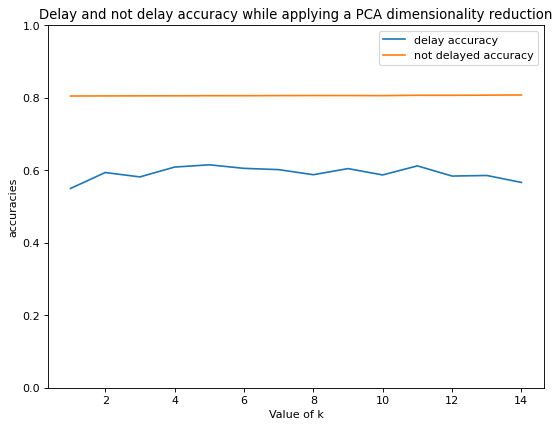

In [60]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(1,15),d_pca,label="delay accuracy")
plt.plot(np.arange(1,15),nd_pca,label="not delayed accuracy")
plt.xlabel("Value of k")
plt.ylabel("accuracies")
plt.ylim(0,1)
plt.legend()
plt.title("Delay and not delay accuracy while applying a PCA dimensionality reduction")
plt.savefig("Viz/pca.png")
plt.show()

In [53]:
#checking that embedding into 1 dimension is enough
x_train,x_test,y_train,y_test = redoSplit(X,Y)
#transforming
pca = PCA(n_components=1)
pca.fit(x_train)
Xpca = pca.transform(x_train)
Xpca -= np.min(Xpca,axis=0);Xpca /= np.max(Xpca,axis=0)
Xtestpca = pca.fit_transform(x_test)
Xtestpca -= np.min(Xtestpca,axis=0);Xtestpca /= np.max(Xtestpca,axis=0)
#fitting
clf = bestFittingMethod(Xpca,y_train)
#confusion matrix
y_pred_test = clf.predict(Xtestpca)
score_test = clf.score(Xtestpca,y_test.to_numpy())
cm_test = confusion_matrix(y_test.to_numpy(),y_pred_test)
n_cm_test = cm_test /np.sum(cm_test,axis=0)
print(n_cm_test)

/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:33:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[0.80505834 0.45      ]
 [0.19494166 0.55      ]]
